In [13]:
# Loading the libraries
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [63]:
all_data = pd.read_csv(r'C:\Users\Gebruiker\Documents\thesiscode\experimental\german_credit_preprocessed.csv', index_col=0)
errors = all_data['errors']
clustering_features_preprocessed = all_data.drop(['predicted_class', 'true_class', 'errors'], axis=1)
all_data.head()

,Age,Job,Credit amount,Duration,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,...,Savings_rich,Check_moderate,Check_no_inf,Check_rich,Age_cat_Young,Age_cat_Adult,Age_cat_Senior,predicted_class,true_class,errors
136,27,2,8613,27,1,0,0,0,0,0,...,1,0,1,0,1,0,0,0,0.0,0.0
76,34,2,3965,42,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1.0,1.0
280,23,2,3368,15,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0.0,0.0
319,27,1,3643,15,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0.0,0.0
174,26,2,3414,21,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1.0,1.0


In [64]:
to_scale = clustering_features_preprocessed.columns
clustering_features_preprocessed[to_scale] = StandardScaler().fit_transform(clustering_features_preprocessed[to_scale])

clustering_features_preprocessed[:5]

,Age,Job,Credit amount,Duration,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,...,Savings_moderate,Savings_no_inf,Savings_quite rich,Savings_rich,Check_moderate,Check_no_inf,Check_rich,Age_cat_Young,Age_cat_Adult,Age_cat_Senior
136,-0.736682,0.222911,2.097685,0.541581,1.659987,-0.077152,-0.250785,-0.547723,-0.620682,-0.109435,...,-0.323381,-0.483298,-0.276465,3.789939,-0.657422,1.249242,-0.250785,1.249242,-0.761209,-0.191859
76,-0.098692,0.222911,0.299478,1.760861,-0.602414,-0.077152,-0.250785,-0.547723,1.611131,-0.109435,...,-0.323381,-0.483298,-0.276465,-0.263857,-0.657422,-0.800485,-0.250785,1.249242,-0.761209,-0.191859
280,-1.101248,0.222911,0.068512,-0.433842,1.659987,-0.077152,-0.250785,-0.547723,-0.620682,-0.109435,...,-0.323381,-0.483298,-0.276465,3.789939,-0.657422,1.249242,-0.250785,-0.800485,-0.761209,-0.191859
319,-0.736682,-1.346756,0.174903,-0.433842,-0.602414,-0.077152,-0.250785,1.825742,-0.620682,-0.109435,...,-0.323381,-0.483298,-0.276465,-0.263857,-0.657422,-0.800485,-0.250785,1.249242,-0.761209,-0.191859
174,-0.827824,0.222911,0.086308,0.053870,-0.602414,-0.077152,3.987480,-0.547723,-0.620682,-0.109435,...,-0.323381,-0.483298,-0.276465,-0.263857,-0.657422,-0.800485,-0.250785,1.249242,-0.761209,-0.191859


In [43]:
# is used to calculate the F-score of the instances in the clusters.
# requires the all_data dataframe (with predicted and true class, but the errors col is not needed)

def F_score(results, class_number):
    true_pos = results.loc[(results["true_class"] == class_number) & (results["predicted_class"] == class_number)]
    true_neg = results.loc[(results["true_class"] != class_number) & (results["predicted_class"] != class_number)]
    false_pos = results.loc[(results["true_class"] != class_number) & (results["predicted_class"] == class_number)]
    false_neg = results.loc[(results["true_class"] == class_number) & (results["predicted_class"] != class_number)]

    try:
        precision =  len(true_pos)/(len(true_pos) + len(false_pos))
    except ZeroDivisionError:
        return 0
    try:
        recall = len(true_pos)/(len(true_pos) + len(false_neg))
    except ZeroDivisionError:
        return 0

    # TODO solve the "float division by zero" error
    try:
        f_score = 2 * ((precision * recall)/(precision + recall))
    except ZeroDivisionError:
        return 0
        
    return f_score

# Calculating the macro average F-score --> will eventually be replaced with weighted F-score
def mean_f_score(results):
    classes = results['true_class'].unique()
    class_list = []
    for i in classes:
        class_i = F_score(results, i)
        class_list.append(class_i)
    mean_f_score = (sum(class_list))/len(classes)
    print('this is the mean F-score of all classes within this cluster in the list: ', mean_f_score)

    return(mean_f_score)

# Calculating the bias for each cluster
def calculate_bias(clustered_data, cluster_number):
    cluster_x = clustered_data.loc[clustered_data["clusters"] == cluster_number]
    remaining_clusters = clustered_data.loc[clustered_data["clusters"] != cluster_number]
    
    # Bias definition: 
    return mean_f_score(remaining_clusters) - mean_f_score(cluster_x)


In [9]:
clus_model_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 2,
}


In [39]:
# calculate the variances of the errors column
def calculate_variance(data):
    # Receives the data within one cluster to calculate the variance

    # Obtain errors column
    errors_col = data['errors']
    # Number of observations
    n = len(data)
    # Mean of the data
    mean = sum(errors_col)/n
    # Squared deviation 
    deviations = [(x - mean) ** 2 for x in errors_col]
    # Variance
    variance = sum(deviations) / n
    return variance

def get_highest_var_cluster(data):
    clusters = data['clusters'].unique()
    highest_variance = 0
    best_cluster = None
    cluster_number = None
    for i in clusters:
        print('this is i:', i)
        cluster_i = data[data['clusters'] == i]
        variance_cluster = calculate_variance(cluster_i)
        print('variance cluster:', variance_cluster)
        print('highest variance:', highest_variance)

        if variance_cluster > highest_variance:
            highest_variance = variance_cluster
            best_cluster = cluster_i
            cluster_number = i
            print('this is the cluster number:', cluster_number)

    return cluster_number


In [46]:
def plot_clusters(data):
#     pca = PCA(n_components=2)
#     transformed = pd.DataFrame({"axis1": np.zeros(len(data)), "axis2" : np.zeros(len(data))})
#     transformed["axis1","axis2"] = pca.fit_transform(data.drop("clusters", axis=1), y=None)
#     transformed["clusters"] = data["clusters"]
    scatterplot = sns.scatterplot(data=data, x="Job", y="Age", hue="clusters")

    plt.show()
    


In [69]:
# Initialisation of clustering_features
clustering_features_preprocessed['clusters'] = 1
clustering_features = clustering_features_preprocessed.copy(deep=True)

clustering_features.head()

,Age,Job,Credit amount,Duration,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,...,Savings_no_inf,Savings_quite rich,Savings_rich,Check_moderate,Check_no_inf,Check_rich,Age_cat_Young,Age_cat_Adult,Age_cat_Senior,clusters
136,-0.736682,0.222911,2.097685,0.541581,1.659987,-0.077152,-0.250785,-0.547723,-0.620682,-0.109435,...,-0.483298,-0.276465,3.789939,-0.657422,1.249242,-0.250785,1.249242,-0.761209,-0.191859,1
76,-0.098692,0.222911,0.299478,1.760861,-0.602414,-0.077152,-0.250785,-0.547723,1.611131,-0.109435,...,-0.483298,-0.276465,-0.263857,-0.657422,-0.800485,-0.250785,1.249242,-0.761209,-0.191859,1
280,-1.101248,0.222911,0.068512,-0.433842,1.659987,-0.077152,-0.250785,-0.547723,-0.620682,-0.109435,...,-0.483298,-0.276465,3.789939,-0.657422,1.249242,-0.250785,-0.800485,-0.761209,-0.191859,1
319,-0.736682,-1.346756,0.174903,-0.433842,-0.602414,-0.077152,-0.250785,1.825742,-0.620682,-0.109435,...,-0.483298,-0.276465,-0.263857,-0.657422,-0.800485,-0.250785,1.249242,-0.761209,-0.191859,1
174,-0.827824,0.222911,0.086308,0.053870,-0.602414,-0.077152,3.987480,-0.547723,-0.620682,-0.109435,...,-0.483298,-0.276465,-0.263857,-0.657422,-0.800485,-0.250785,1.249242,-0.761209,-0.191859,1


Splitting on cluster 1
this is the mean F-score of all classes within this cluster in the list:  0.5147563486616334
this is the mean F-score of all classes within this cluster in the list:  0.4685694869181108
this is the mean F-score of all classes within this cluster in the list:  0.4685694869181108
this is the mean F-score of all classes within this cluster in the list:  0.5147563486616334


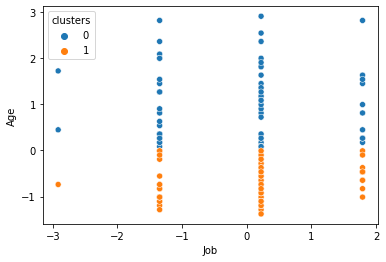

this is i: 1
variance cluster: 0.22644838741299841
highest variance: 0
this is the cluster number: 1
this is i: 0
variance cluster: 0.22383217993079602
highest variance: 0.22644838741299841
the end
Splitting on cluster 1
this is the mean F-score of all classes within this cluster in the list:  0.492467043314501
this is the mean F-score of all classes within this cluster in the list:  0.5025234318673396
this is the mean F-score of all classes within this cluster in the list:  0.5025234318673396
this is the mean F-score of all classes within this cluster in the list:  0.492467043314501
<ipython-input-70-1dc4d978a770>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_bias_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(high_bias_clus

In [70]:
MAX_ITER = 10 # --> in each iteration we split on the cluster with the highest variance
x = 1 # cluster number
bias_prev_iteration_cluster = 0

for i in range(1, MAX_ITER):
    print('Splitting on cluster', x)
    # select the instances with cluster X as dataset
    high_bias_cluster = clustering_features.loc[clustering_features['clusters'] == x]
    high_bias_cluster.drop('clusters', axis=1)

    # Apply Kmeans 
    kmeans_algo = KMeans(n_clusters=2, **clus_model_kwargs).fit(high_bias_cluster) 
    high_bias_cluster['new_clusters'] = pd.DataFrame(kmeans_algo.predict(high_bias_cluster),index=high_bias_cluster.index) 
    
    new_clustering_features = clustering_features.copy(deep=True)
    new_clustering_features['clusters'] = high_bias_cluster['new_clusters'].combine_first(new_clustering_features['clusters'])
    new_clustering_features['true_class'] = all_data[['true_class']]
    new_clustering_features['predicted_class'] = all_data[['predicted_class']]

    #todo: check whether adding the predicted and true class now works
    
    # calculate bias for each of the two clusters
    negative_bias_0 = calculate_bias(new_clustering_features, 0)
    negative_bias_1 = calculate_bias(new_clustering_features, 1)

    new_clustering_features.drop(['true_class', 'predicted_class'], axis=1)

    if max(negative_bias_0, negative_bias_1) >= bias_prev_iteration_cluster:
        # select cluster with highest negative bias and merge new cluster assignments with the df
        bias_prev_iteration_cluster = max(negative_bias_0, negative_bias_1)
        clustering_features = new_clustering_features.copy(deep=True)
        plot_clusters(clustering_features)
    else:
        break
        print('no clusters with a higher bias are left')
    
    clustering_features = clustering_features.join(errors, how='left')
    x = get_highest_var_cluster(clustering_features)
    clustering_features = clustering_features.drop('errors', axis=1)
    print('the end')


Possible solution for the boolean indexing error:
https://www.reddit.com/r/learnpython/comments/53yjbe/pandas_boolean_filtering/

In [ ]:
# exporting the biased cluster dataframe for further analysis
# resulting_cluster.to_csv('identified_cluster.csv')

In [ ]:
        # new_clustering_features = clustering_features.join(high_bias_cluster['new_clusters'], how='left')
    
    # new_clustering_features['clusters'] = new_clustering_features['new_clusters'].combine_first(new_clustering_features['clusters'])
    # new_clustering_features.drop('new_clusters', axis=1)